## Branin-Hoo Function
https://www.sfu.ca/~ssurjano/branin.html
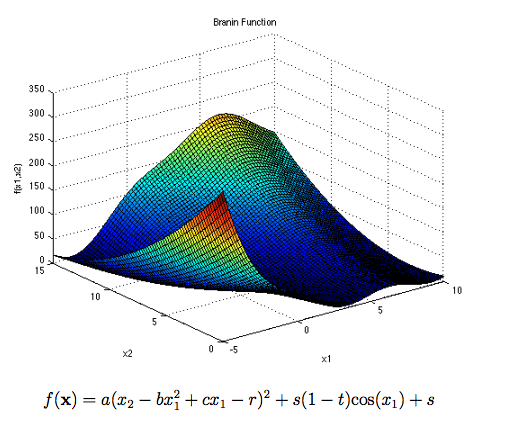

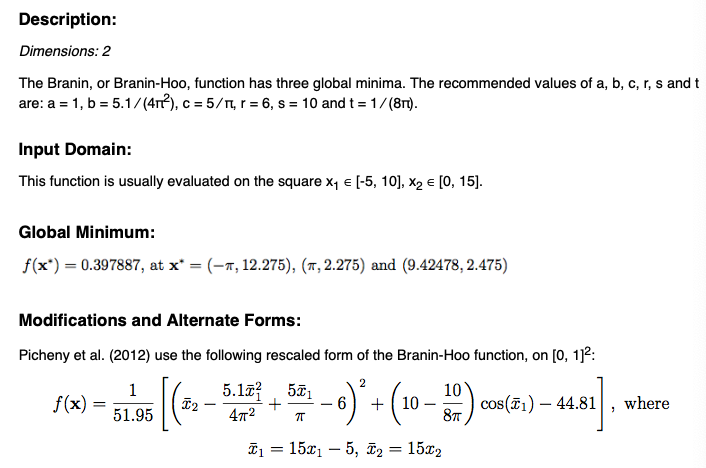

In [12]:
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn.model_selection import train_test_split
import random

In [13]:
# Set random seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [14]:
# Define Branin-Hoo function
def branin(x):
    x1 = x[..., 0]
    x2 = x[..., 1]
    a = 1.
    b = 5.1 / (4 * np.pi**2)
    c = 5. / np.pi
    r = 6.
    s = 10.
    t = 1. / (8 * np.pi)
    return a * (x2 - b * x1**2 + c * x1 - r)**2 + s * (1 - t) * torch.cos(x1) + s

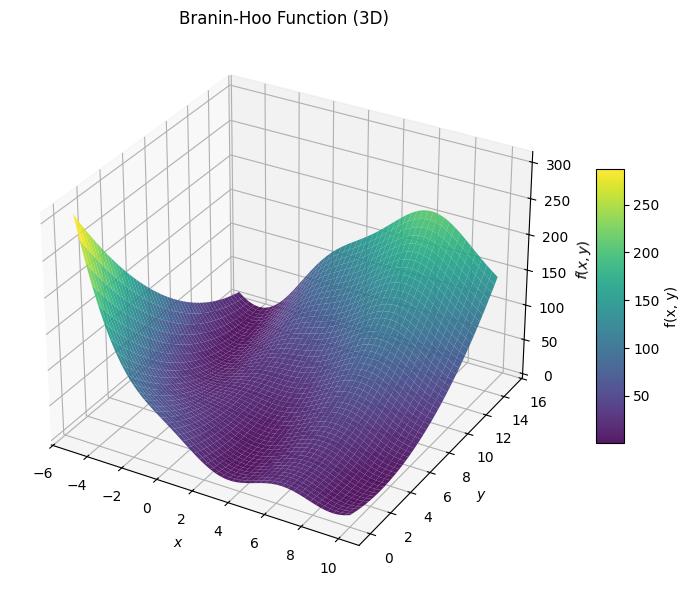

In [25]:
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plots

# Define Branin-Hoo function (NumPy version)
def branin_np(x, y):
    a = 1.0
    b = 5.1 / (4.0 * np.pi**2)
    c = 5.0 / np.pi
    r = 6.0
    s = 10.0
    t = 1.0 / (8.0 * np.pi)
    return a * (y - b * x**2 + c * x - r)**2 + s * (1 - t) * np.cos(x) + s

# Compute function values
z_true = branin_np(x, y)

# Plotting
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x, y, z_true, cmap='viridis', edgecolor='none', alpha=0.9)
ax.set_title("Branin-Hoo Function (3D)")
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$f(x, y)$')

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='f(x, y)')
plt.tight_layout()
plt.show()


In [15]:
# 1. Data Generation
nv = 50
xv = np.linspace(-5., 10., nv)
yv = np.linspace(0., 15., nv)
x, y = np.meshgrid(xv, yv)
xy = np.stack([x.ravel(), y.ravel()], axis=1)
X = torch.tensor(xy, dtype=torch.float32)
Z = branin(X).unsqueeze(-1)

In [16]:
# Add noise
noise_level = 5.0
Z_noisy = Z + torch.randn_like(Z) * noise_level


In [17]:
# 2. Train/Test split
X_train, _, Y_train, _ = train_test_split(X.numpy(), Z_noisy.numpy(), test_size=0.95, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)

In [18]:
# Normalize target
y_mean = Y_train.mean()
y_std = Y_train.std()
y_mean = y_mean.item()
y_std = y_std.item()
Y_train_norm = (Y_train - y_mean) / y_std


In [19]:
# 3. Define GPyTorch model
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=2)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [20]:
# 4. Likelihood and Model
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint=gpytorch.constraints.Interval(1e-5, 10.0)
)
model = GPModel(X_train, Y_train_norm.squeeze(), likelihood)

# Set hyperparameters
model.covar_module.base_kernel.lengthscale = torch.tensor([2.0, 1.0])
model.covar_module.base_kernel.register_prior("lengthscale_prior", gpytorch.priors.NormalPrior(1.0, 1.0), "lengthscale")
model.covar_module.base_kernel.raw_lengthscale_constraint = gpytorch.constraints.Interval(0.1, 100.0)

model.covar_module.outputscale = 1.0
model.covar_module.register_prior("outputscale_prior", gpytorch.priors.NormalPrior(1.0, 1.0), "outputscale")
model.covar_module.raw_outputscale_constraint = gpytorch.constraints.Interval(0.01, 100.0)

likelihood.noise = 0.1

In [21]:
# 5. Training
model.train()
likelihood.train()
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def closure():
    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, Y_train_norm.squeeze())
    loss.backward()
    return loss

for i in range(50):
    optimizer.step(closure)

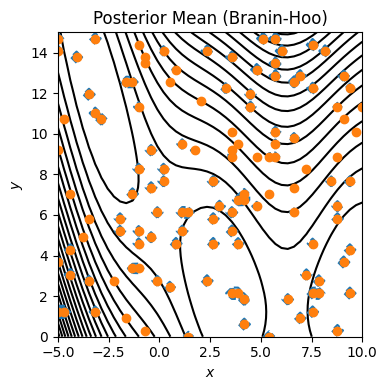

In [22]:
# 6. Prediction on meshgrid
model.eval()
likelihood.eval()
X_test = torch.tensor(xy, dtype=torch.float32)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(X_test))
    prediction_mean = observed_pred.mean.numpy()
    prediction_std = observed_pred.stddev.numpy()

zfit_original = prediction_mean * y_std + y_mean
zstd_original = prediction_std * y_std

zfit = zfit_original.reshape(x.shape)
zstd = zstd_original.reshape(x.shape)

# 7. Plotting posterior mean
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Posterior Mean (Branin-Hoo)")
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xlim((-5, 10))
ax.set_ylim((0, 15))
ax.set_aspect('equal')
ax.contour(x, y, branin(torch.tensor(np.column_stack((x.flatten(), y.flatten())), dtype=torch.float32)).reshape(x.shape), levels=20, colors='k')
ax.contour(x, y, zfit, levels=20, colors='C0', linestyles='--')
ax.plot(*X_train.T, 'o', color='C1')

plt.tight_layout()
plt.show()

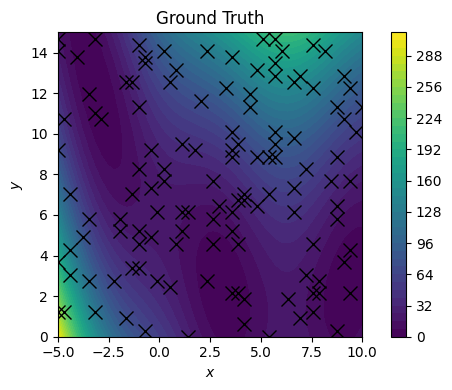

In [28]:
# 7. Plotting ground truth (to match the provided image style)
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Ground Truth")
ax.set_xlabel('$x$')  # Adjusting to match the code's context (not 'C')
ax.set_ylabel('$y$')  # Adjusting to match the code's context (not an arrow)
ax.set_xlim((-5, 10))
ax.set_ylim((0, 15))
ax.set_aspect('equal')

# Plot filled contour (heatmap) of the ground truth Branin-Hoo function
Z_ground = branin(torch.tensor(xy, dtype=torch.float32)).reshape(x.shape).numpy()
contour = ax.contourf(x, y, Z_ground, levels=50, cmap='viridis')  # Using 'viridis' colormap to match the provided image
plt.colorbar(contour, ax=ax)  # Add colorbar to show the scale

# Plot training points as black 'x' markers
ax.plot(*X_train.T, 'x', color='black', markersize=10)

plt.tight_layout()
plt.show()

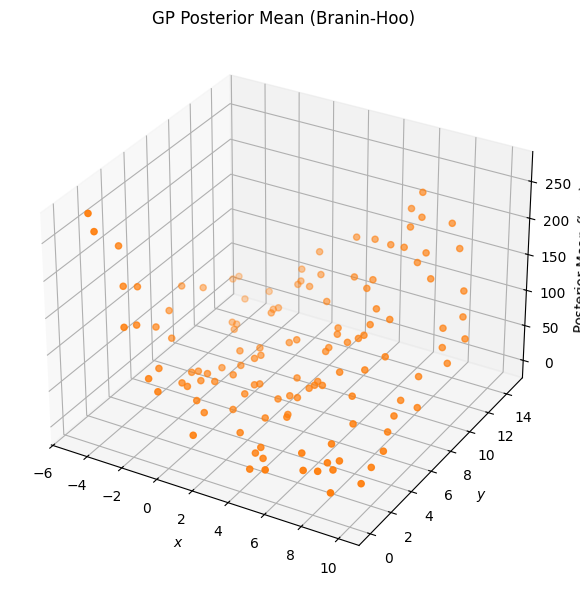

In [30]:
# 3D plot of posterior mean
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Surface plot
#surf = ax.plot_surface(x, y, zfit, cmap='viridis', edgecolor='none', alpha=0.9)

# Training points overlay (flattened to zfit domain)
ax.scatter(X_train[:, 0], X_train[:, 1], (Y_train.numpy().flatten()), color='C1', label='Train samples')

# Labels and styling
ax.set_title("GP Posterior Mean (Branin-Hoo)")
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('Posterior Mean $f(x, y)$')

# Colorbar
#fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Posterior mean')

plt.tight_layout()
plt.show()

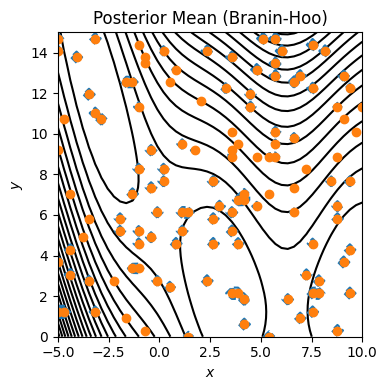

In [27]:
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn.model_selection import train_test_split
import random

# Set random seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Define Branin-Hoo function
def branin(x):
    x1 = x[..., 0]
    x2 = x[..., 1]
    a = 1.
    b = 5.1 / (4 * np.pi**2)
    c = 5. / np.pi
    r = 6.
    s = 10.
    t = 1. / (8 * np.pi)
    return a * (x2 - b * x1**2 + c * x1 - r)**2 + s * (1 - t) * torch.cos(x1) + s

# 1. Data Generation
nv = 50
xv = np.linspace(-5., 10., nv)
yv = np.linspace(0., 15., nv)
x, y = np.meshgrid(xv, yv)
xy = np.stack([x.ravel(), y.ravel()], axis=1)
X = torch.tensor(xy, dtype=torch.float32)
Z = branin(X).unsqueeze(-1)

# Add noise
noise_level = 5.0
Z_noisy = Z + torch.randn_like(Z) * noise_level

# 2. Train/Test split
X_train, _, Y_train, _ = train_test_split(X.numpy(), Z_noisy.numpy(), test_size=0.95, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.float32)

# Normalize target
y_mean = Y_train.mean()
y_std = Y_train.std()
y_mean = y_mean.item()
y_std = y_std.item()
Y_train_norm = (Y_train - y_mean) / y_std

# 3. Define GPyTorch model
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=2)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# 4. Likelihood and Model
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint=gpytorch.constraints.Interval(1e-5, 10.0)
)
model = GPModel(X_train, Y_train_norm.squeeze(), likelihood)

# Set hyperparameters
model.covar_module.base_kernel.lengthscale = torch.tensor([2.0, 1.0])
model.covar_module.base_kernel.register_prior("lengthscale_prior", gpytorch.priors.NormalPrior(1.0, 1.0), "lengthscale")
model.covar_module.base_kernel.raw_lengthscale_constraint = gpytorch.constraints.Interval(0.1, 100.0)

model.covar_module.outputscale = 1.0
model.covar_module.register_prior("outputscale_prior", gpytorch.priors.NormalPrior(1.0, 1.0), "outputscale")
model.covar_module.raw_outputscale_constraint = gpytorch.constraints.Interval(0.01, 100.0)

likelihood.noise = 0.1

# 5. Training
model.train()
likelihood.train()
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def closure():
    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, Y_train_norm.squeeze())
    loss.backward()
    return loss

for i in range(50):
    optimizer.step(closure)

# 6. Prediction on meshgrid
model.eval()
likelihood.eval()
X_test = torch.tensor(xy, dtype=torch.float32)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(X_test))
    prediction_mean = observed_pred.mean.numpy()
    prediction_std = observed_pred.stddev.numpy()

zfit_original = prediction_mean * y_std + y_mean
zstd_original = prediction_std * y_std

zfit = zfit_original.reshape(x.shape)
zstd = zstd_original.reshape(x.shape)

# 7. Plotting posterior mean
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Posterior Mean (Branin-Hoo)")
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xlim((-5, 10))
ax.set_ylim((0, 15))
ax.set_aspect('equal')
ax.contour(x, y, branin(torch.tensor(np.column_stack((x.flatten(), y.flatten())), dtype=torch.float32)).reshape(x.shape), levels=20, colors='k')
ax.contour(x, y, zfit, levels=20, colors='C0', linestyles='--')
ax.plot(*X_train.T, 'o', color='C1')

plt.tight_layout()
plt.show()


=== Iteration 1 ===
Best observed (normalized): 3.6865562801369527


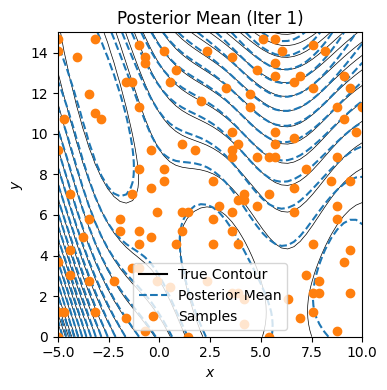


=== Iteration 2 ===
Best observed (normalized): 4.307087241865577


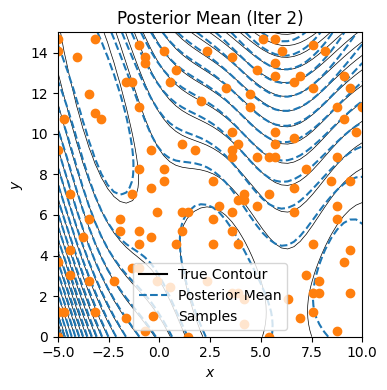


=== Iteration 3 ===
Best observed (normalized): 4.500819100274869


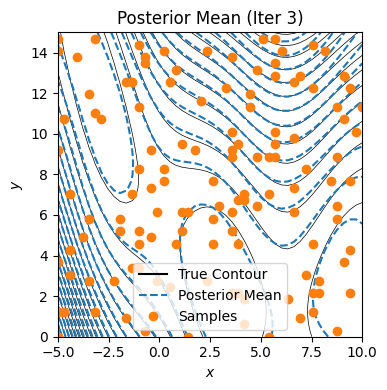


=== Iteration 4 ===
Best observed (normalized): 4.500819100274869


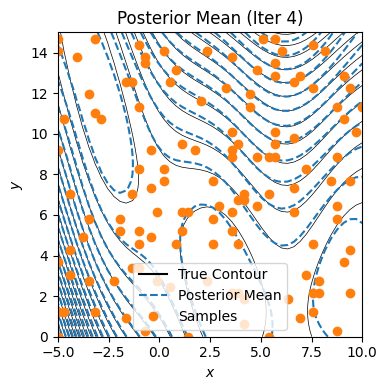


=== Iteration 5 ===
Best observed (normalized): 4.500819100274869


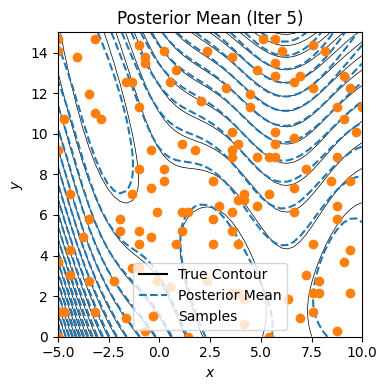


=== Iteration 6 ===
Best observed (normalized): 4.500819100274869


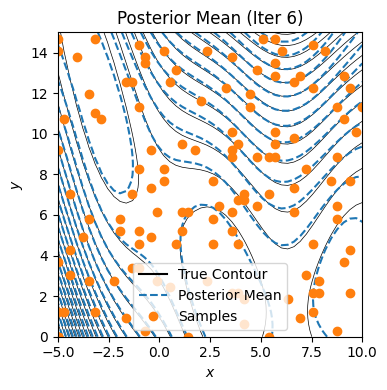


=== Iteration 7 ===
Best observed (normalized): 4.500819100274869


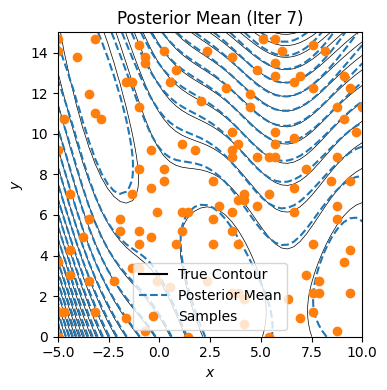


=== Iteration 8 ===
Best observed (normalized): 4.591443745738705


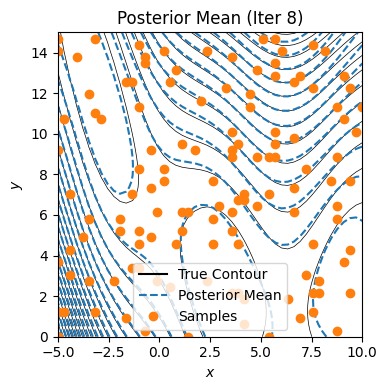


=== Iteration 9 ===
Best observed (normalized): 4.591443745738705


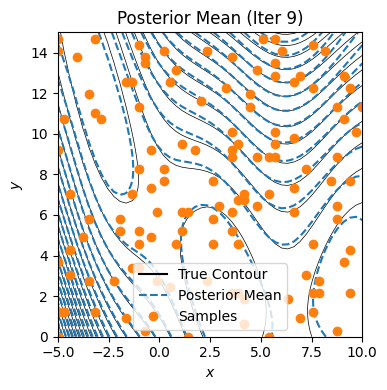


=== Iteration 10 ===
Best observed (normalized): 4.591443745738705


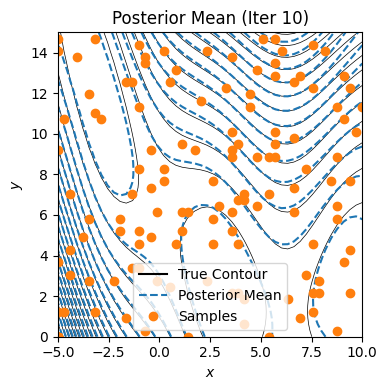

In [35]:
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sklearn.model_selection import train_test_split
import random
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition.analytic import ExpectedImprovement, LogExpectedImprovement
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood

# Set random seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.set_default_dtype(torch.float64)

# Define Branin-Hoo function
def branin(x):
    x1 = x[..., 0]
    x2 = x[..., 1]
    a = 1.
    b = 5.1 / (4 * np.pi**2)
    c = 5. / np.pi
    r = 6.
    s = 10.
    t = 1. / (8 * np.pi)
    return a * (x2 - b * x1**2 + c * x1 - r)**2 + s * (1 - t) * torch.cos(x1) + s

# 1. Data Generation
nv = 50
xv = np.linspace(-5., 10., nv)
yv = np.linspace(0., 15., nv)
x, y = np.meshgrid(xv, yv)
xy = np.stack([x.ravel(), y.ravel()], axis=1)
X = torch.tensor(xy, dtype=torch.float64)
Z = branin(X).unsqueeze(-1)

# Add noise
noise_level = 5.0
Z_noisy = Z + torch.randn_like(Z) * noise_level

# 2. Train/Test split
X_train, _, Y_train, _ = train_test_split(X.numpy(), Z_noisy.numpy(), test_size=0.95, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float64)
Y_train = torch.tensor(Y_train, dtype=torch.float64)

# Normalize target
y_mean = Y_train.mean()
y_std = Y_train.std()
y_mean = y_mean.item()
y_std = y_std.item()
Y_train_norm = (Y_train - y_mean) / y_std

# Normalize input to unit cube
x_min = X_train.min(0).values
x_max = X_train.max(0).values
train_x_scaled = (X_train - x_min) / (x_max - x_min)
bounds = torch.tensor([[0., 0.], [1., 1.]], dtype=torch.float64)

# Convert to torch double
train_x = train_x_scaled
train_y = Y_train_norm.squeeze()

# Define black-box function for EI evaluation
def blackbox_2d(x_scaled):
    x_real = x_scaled * (x_max - x_min) + x_min
    z_clean = branin(x_real)
    z_noisy = z_clean + torch.randn_like(z_clean) * noise_level
    z_norm = (z_noisy - y_mean) / y_std
    return z_norm

# Grid for plotting
X_plot = torch.tensor(xy, dtype=torch.float64)
X_plot_scaled = (X_plot - x_min) / (x_max - x_min)

# Optimization loop with EI
num_iterations = 10
for i in range(num_iterations):
    print(f"\n=== Iteration {i+1} ===")
    print("Best observed (normalized):", train_y.max().item())

    # 3. Define and fit GP model using botorch's SingleTaskGP
    model = SingleTaskGP(train_x, train_y.unsqueeze(-1))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)

    # 4. Acquisition function (Expected Improvement)
    ei = LogExpectedImprovement(model=model, best_f=train_y.max())
    next_x_scaled, _ = optimize_acqf(ei, bounds=bounds, q=1, num_restarts=10, raw_samples=50)

    # 5. Evaluate and update training data
    next_y = blackbox_2d(next_x_scaled)
    train_x = torch.cat([train_x, next_x_scaled], dim=0)
    train_y = torch.cat([train_y, next_y.view(-1)], dim=0)

    # 6. Predict on full grid
    model.eval()
    with torch.no_grad():
        posterior = model.posterior(X_plot_scaled)
        pred_mean = posterior.mean.numpy().reshape(x.shape)
        pred_std = posterior.variance.sqrt().numpy().reshape(x.shape)

    # 7. Plot posterior mean
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_title(f"Posterior Mean (Iter {i+1})")
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_xlim((-5, 10))
    ax.set_ylim((0, 15))
    ax.set_aspect('equal')
    ax.contour(x, y, branin(X).reshape(x.shape), levels=20, colors='k', linewidths=0.5)
    ax.contour(x, y, pred_mean * y_std + y_mean, levels=20, colors='C0', linestyles='--')
    ax.plot((train_x * (x_max - x_min) + x_min)[:, 0].numpy(),
            (train_x * (x_max - x_min) + x_min)[:, 1].numpy(),
            'o', color='C1')
    ax.legend(handles=[
        mlines.Line2D([], [], color='black', label='True Contour'),
        mlines.Line2D([], [], color='C0', linestyle='--', label='Posterior Mean'),
        mlines.Line2D([], [], color='C1', marker='o', linestyle='None', label='Samples')
    ])
    plt.tight_layout()
    plt.show()

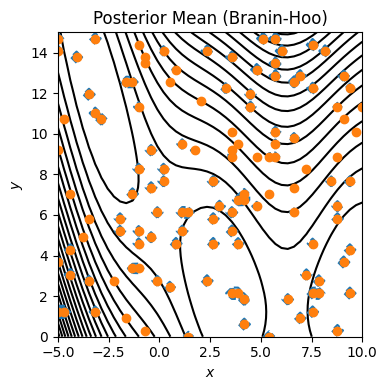

In [ ]:
# 6. Prediction on meshgrid
model.eval()
likelihood.eval()
X_test = torch.tensor(xy, dtype=torch.float32)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(X_test))
    prediction_mean = observed_pred.mean.numpy()
    prediction_std = observed_pred.stddev.numpy()

zfit_original = prediction_mean * y_std + y_mean
zstd_original = prediction_std * y_std

zfit = zfit_original.reshape(x.shape)
zstd = zstd_original.reshape(x.shape)

# 7. Plotting posterior mean
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title("Posterior Mean (Branin-Hoo)")
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_xlim((-5, 10))
ax.set_ylim((0, 15))
ax.set_aspect('equal')
ax.contour(x, y, branin(torch.tensor(np.column_stack((x.flatten(), y.flatten())), dtype=torch.float32)).reshape(x.shape), levels=20, colors='k')
ax.contour(x, y, zfit, levels=20, colors='C0', linestyles='--')
ax.plot(*X_train.T, 'o', color='C1')

plt.tight_layout()
plt.show()